In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
import datetime

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_budgets/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [5]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [6]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3908: PerformanceWarning: Increasing numbe

### Subselect time period

### Section transports

In [7]:
vol_trsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_slt.nc').vol
slt_trsp = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_slt.nc').salt

## Define the section lines 

In [8]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [9]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [10]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [11]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

In [ ]:
terms = ['tendV', 'forcV', 'ConvV', 'totalV']

budg_volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Volume tendency (m^3/s)
    tendV = (budg_vol.tendV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sea surface forcing on volume (m^3/s)
    forcV = (budg_vol.forcV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of volume transport (m^3/s)
    ConvV = ((budg_vol.hConvV+budg_vol.vConvV)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalV = ConvV + forcV
    
    results = dask.compute(tendV*Sv, forcV*Sv, ConvV*Sv, totalV*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_volume.append(budg)

In [13]:
region = ['spna', 'nsea', 'lsea']
budg_volume = xr.concat(budg_volume,pd.Index(region, name='region'))

### Salinity budget

In [14]:
terms = ['tendSln', 'forcSln', 'adv_ConvSln', 'dif_ConvSln', 'ConvSln', 'totalSln', 'ConvVSln', 'SlnV']

budg_sln = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Temperature tendency (psu m^3/s)
    tendSln = (budg_vol.tendSln*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Forcing (psu m^3/s)
    forcSln = (budg_vol.forcSln*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Advection (psu m^3/s)
    adv_ConvSln = ((budg_vol.adv_hConvSln+budg_vol.adv_vConvSln)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Diffusion (psu m^3/s)
    dif_ConvSln = ((budg_vol.dif_hConvSln+budg_vol.dif_vConvSln)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Total convergence (psu m^3/s)
    ConvSln = adv_ConvSln + dif_ConvSln
    
    # Sum of terms (psu m^3/s)
    totalSln = ConvSln + forcSln
    
    # Salinity change due to volume convergence (psu m^3/s)
    ConvVSln = (((budg_vol.hConvV + budg_vol.vConvV)*main.SALT)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Total salinity (psu m^3)
    SlnV = ((main.SALT*vol)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    results = dask.compute(tendSln.reset_coords(drop=True)*Sv, forcSln.reset_coords(drop=True)*Sv, 
                           adv_ConvSln.reset_coords(drop=True)*Sv, dif_ConvSln.reset_coords(drop=True)*Sv, 
                           ConvSln.reset_coords(drop=True)*Sv, totalSln.reset_coords(drop=True)*Sv,
                           ConvVSln.reset_coords(drop=True)*Sv, SlnV.reset_coords(drop=True))
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_sln.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [15]:
region = ['spna', 'nsea', 'lsea']
budg_sln = xr.concat(budg_sln,pd.Index(region, name='region'))

#### Save to netcdf

In [16]:
ds = budg_sln.reset_coords(drop=True).to_dataset(name='budg_sln')

In [17]:
ds.to_netcdf('/mnt/efs/data/ecco/ecco_budg_sln.nc', format='NETCDF4')

In [18]:
budg_sln = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_sln.nc').budg_sln

### Plots

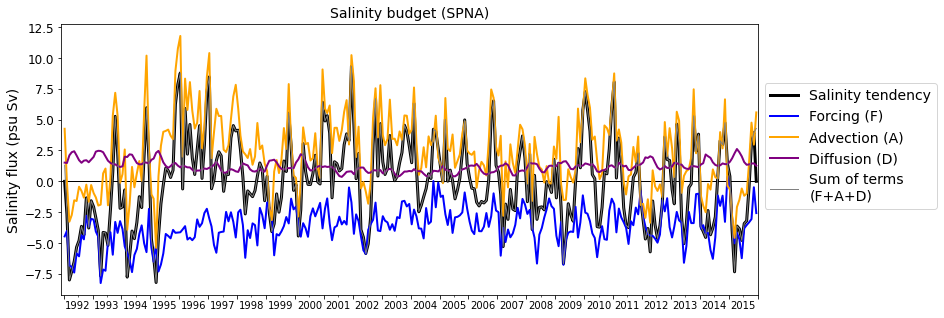

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Salinity budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='tendSln'), lw=3, color='black',label='Salinity tendency')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='forcSln'), lw=2, color='blue',label='Forcing (F)')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='adv_ConvSln'), lw=2, color='orange',label='Advection (A)')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='dif_ConvSln'), lw=2, color='purple',label='Diffusion (D)')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='totalSln'), lw=1, color='grey',
        label='Sum of terms\n(F+A+D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salinity flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

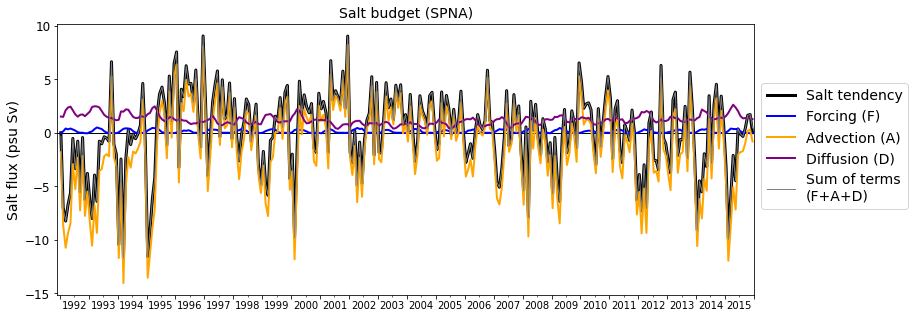

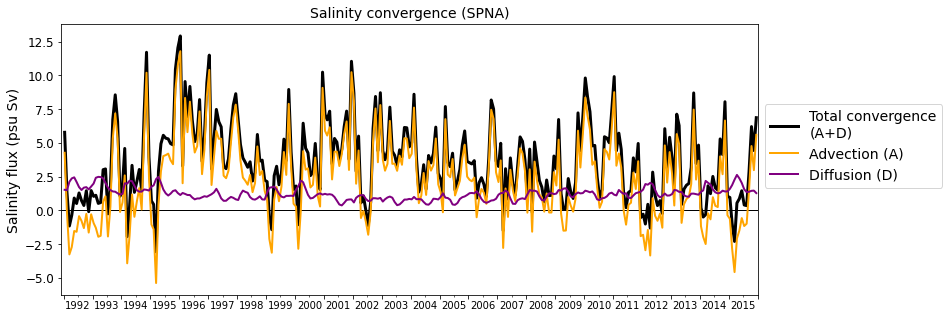

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Salinity convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='ConvSln'), lw=3, color='k', label='Total convergence\n(A+D)')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='adv_ConvSln'), lw=2, color='orange', label='Advection (A)')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='dif_ConvSln'), lw=2, color='purple', label='Diffusion (D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salinity flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

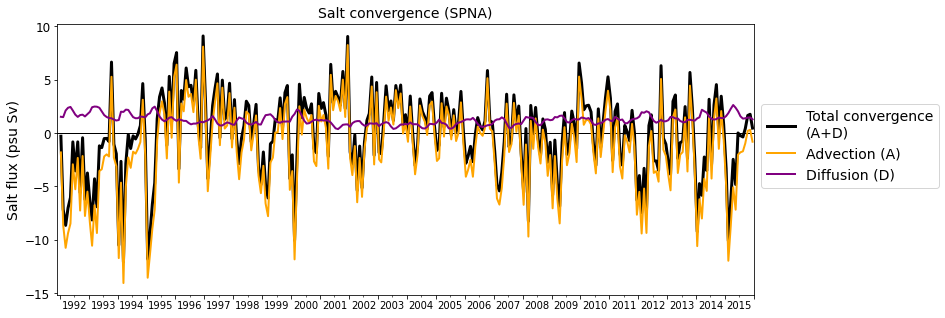

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*


In [21]:
ConvS_spna_bnd = slt_trsp.sel(section='Newfoundland Iberia') + slt_trsp.sel(section='English Channel') \
                    - slt_trsp.sel(section='Hudson Strait') - slt_trsp.sel(section='Davis Strait') \
                    - slt_trsp.sel(section='Denmark Strait') - slt_trsp.sel(section='Iceland Faroe') \
                    - slt_trsp.sel(section='Faroe Scotland')

In [22]:
ConvS_nsea_bnd = slt_trsp.sel(section='Denmark Strait') + slt_trsp.sel(section='Iceland Faroe') \
                    + slt_trsp.sel(section='Faroe Scotland') + slt_trsp.sel(section='Scotland Norway') \
                    - slt_trsp.sel(section='Fram Strait') - slt_trsp.sel(section='Barents Sea')

In [23]:
ConvS_lsea_bnd = slt_trsp.sel(section='Labrador Greenland') - slt_trsp.sel(section='Hudson Strait') \
                    - slt_trsp.sel(section='Davis Strait')

In [26]:
ConvSln_spna_bnd = ConvS_spna_bnd - budg_sln.sel(region='spna',term='ConvVSln')
ConvSln_nsea_bnd = ConvS_nsea_bnd - budg_sln.sel(region='nsea',term='ConvVSln')
ConvSln_lsea_bnd = ConvS_lsea_bnd - budg_sln.sel(region='lsea',term='ConvVSln')

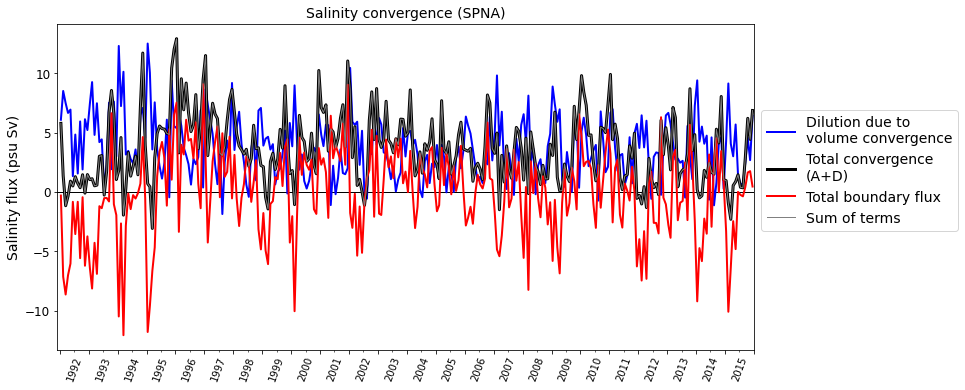

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salinity convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_sln.time, -budg_sln.sel(region='spna',term='ConvVSln'), lw=2, color='b', 
        label='Dilution due to\nvolume convergence')
ax.plot(budg_sln.time, budg_sln.sel(region='spna',term='ConvSln'), lw=3, color='k', label='Total convergence\n(A+D)')
ax.plot(ConvS_spna_bnd.time, ConvS_spna_bnd, lw=2, color='r', ls='-', label='Total boundary flux')
ax.plot(ConvSln_spna_bnd.time, ConvSln_spna_bnd, lw=1, color='grey', ls='-', label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salinity flux (psu Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.setp( ax.xaxis.get_minorticklabels(), rotation=70 )

plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/mnt/efs/figure.png')
plt.show()

In [31]:
from scipy import stats

In [32]:
stats.pearsonr(ConvS_spna_bnd,budg_sln.sel(region='spna',term='ConvSln'))

(0.7208028322249243, 1.9453630601071078e-47)

In [33]:
stats.pearsonr(-budg_sln.sel(region='spna',term='ConvVSln'),budg_sln.sel(region='spna',term='ConvSln'))

(0.0697861104726471, 0.23776209648851662)

In [34]:
stats.pearsonr(-budg_sln.sel(region='spna',term='ConvVSln'),ConvS_spna_bnd)

(-0.6411477300402109, 9.623818213310975e-35)

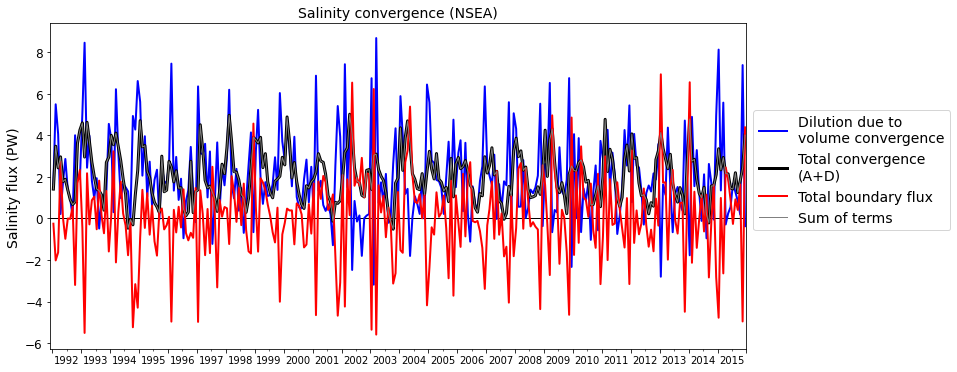

In [48]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Salinity convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_sln.time, -budg_sln.sel(region='nsea',term='ConvVSln'), lw=2, color='b', 
        label='Dilution due to\nvolume convergence')
ax.plot(budg_sln.time, budg_sln.sel(region='nsea',term='ConvSln'), lw=3, color='k', label='Total convergence\n(A+D)')
ax.plot(ConvS_nsea_bnd.time, ConvS_nsea_bnd, lw=2, color='r', ls='-', label='Total boundary flux')
ax.plot(ConvSln_nsea_bnd.time, ConvSln_nsea_bnd, lw=1, color='grey', ls='-', label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salinity flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/mnt/efs/figure.png')
plt.show()

In [39]:
stats.pearsonr(ConvS_nsea_bnd,budg_sln.sel(region='nsea',term='ConvSln'))

(0.3091976584942709, 8.496216350324681e-08)

In [40]:
stats.pearsonr(-budg_sln.sel(region='nsea',term='ConvVSln'),budg_sln.sel(region='nsea',term='ConvSln'))

(0.2457305646518296, 2.4769990100035083e-05)

In [41]:
stats.pearsonr(-budg_sln.sel(region='nsea',term='ConvVSln'),ConvS_nsea_bnd)

(-0.8458574392137829, 4.838897324605331e-80)

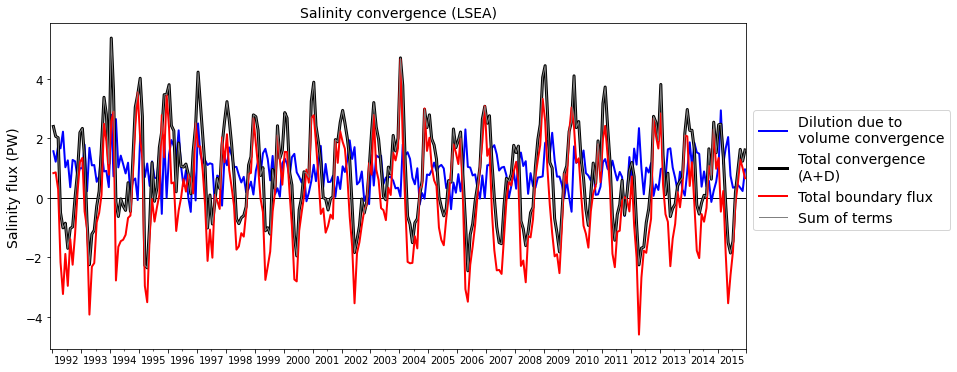

In [49]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title(r'Salinity convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_sln.time, -budg_sln.sel(region='lsea',term='ConvVSln'), lw=2, color='b', 
        label='Dilution due to\nvolume convergence')
ax.plot(budg_sln.time, budg_sln.sel(region='lsea',term='ConvSln'), lw=3, color='k', label='Total convergence\n(A+D)')
ax.plot(ConvS_lsea_bnd.time, ConvS_lsea_bnd, lw=2, color='r', ls='-', label='Total boundary flux')
ax.plot(ConvSln_lsea_bnd.time, ConvSln_lsea_bnd, lw=1, color='grey', ls='-', label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax.set_ylabel('Salinity flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

plt.savefig('/mnt/efs/figure.png')
plt.show()

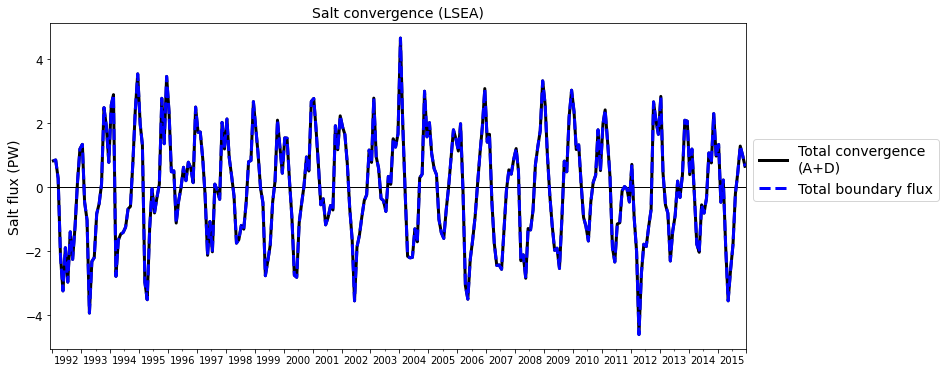

In [43]:
stats.pearsonr(ConvS_lsea_bnd,budg_sln.sel(region='lsea',term='ConvSln'))

(0.9272162233750351, 5.271690815159757e-124)

In [44]:
stats.pearsonr(-budg_sln.sel(region='lsea',term='ConvVSln'),budg_sln.sel(region='lsea',term='ConvSln'))

(0.05817544512479911, 0.32520899404997855)

In [45]:
stats.pearsonr(-budg_sln.sel(region='lsea',term='ConvVSln'),ConvS_lsea_bnd)

(-0.3199483882667511, 2.8124304588324195e-08)